In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)
MBExp   = loadmat(exp_folder+'merge\\merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_1Hz.mat'
                  , squeeze_me =True)

In [4]:
BarPos = MBExp['bin_pos']

In [5]:
RFprop = RFprop['RF_properties']

In [6]:
STK = SVDnSTK['gauss_RF']

# plot STK

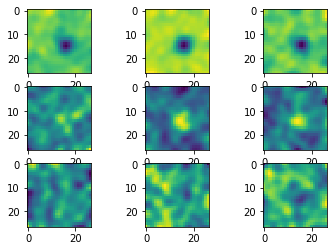

In [7]:
cn = 42
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].imshow(STK[i,:,:,cn-1])

# plot SK

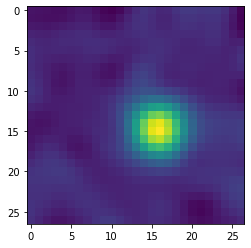

In [8]:
SK = SVDnSTK['SVD_SK'][cn-1]
plt.imshow(SK)

In [9]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2)),  x-x0, y-y0

In [10]:
micro_per_pixel = BS['micro_per_pixel']
RFellipse, xaxis, yaxis = Gaussian_filter_2d_Rot(
                                np.arange(1,801), np.arange(1,601), RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'], 
                                RFprop[cn-1]['X_Width']/1.5/micro_per_pixel, RFprop[cn-1]['Y_Width']/1.5/micro_per_pixel,
                                RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])

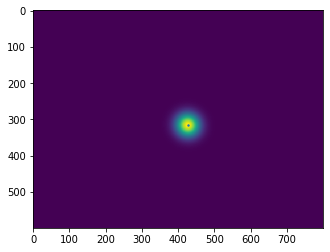

In [11]:
## SVD_SK on display area (whole OLED)
plt.imshow(RFellipse)
plt.scatter(RFprop[cn-1]['X_Coor']-1, RFprop[cn-1]['Y_Coor']-1, s=2)

316


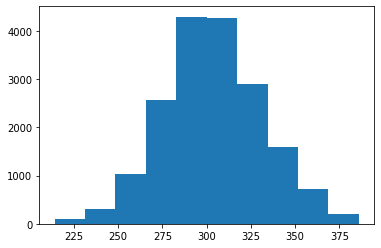

In [12]:
plt.hist(BarPos-100)
print(int(RFprop[cn-1]['Y_Coor']-0.5))

# conv[SK, Bar]

In [13]:
if direction == 'UD':
    Inten = np.array([np.sum(RFellipse[bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],
                              BS['meaCenter_x']-BS['bar_le']-1:BS['meaCenter_x']+BS['bar_wid']])  for bp in BarPos])

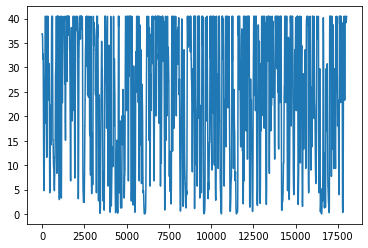

In [14]:
plt.plot(Inten)

# MI and STA

In [15]:
x = Inten
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60.
T=np.arange(len(x))*dt+dt
v = ndimage.gaussian_filter1d(x.copy(), sigma=5, order=1, mode='reflect')/dt

xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)

rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], np.append(0,T))

(-1, 1)

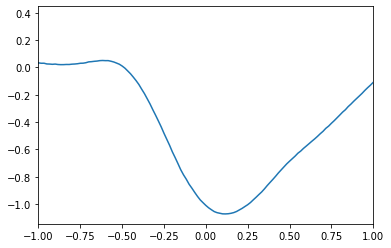

In [16]:
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')

plt.plot(T-T[int(len(T)/2)], nXcorr)
plt.xlim([-1, 1])

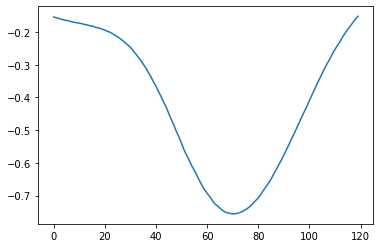

In [34]:
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')
XcT = T-T[int(len(T)/2)]
plt.plot(nXcorr[np.arange(np.where(XcT == -1)[0],np.where(XcT == 1)[0])])

In [17]:
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, [-1,1])

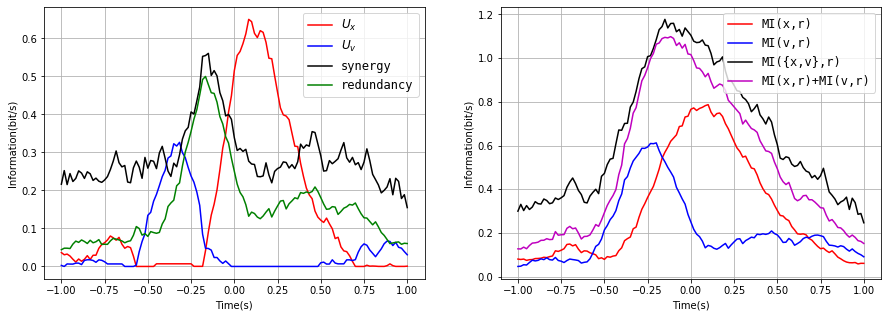

In [18]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')],'r-')
ax2.plot(timeshift,Information[('Beer','UIv')],'b-')
ax2.plot(timeshift,Information[('Beer','Syn')],'k-')
ax2.plot(timeshift,Information[('Beer','Red')],'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()
    
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+
                   Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

In [19]:
x = BarPos
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60.
T=np.arange(len(x))*dt+dt
v = ndimage.gaussian_filter1d(x.copy(), sigma=5, order=1, mode='reflect')/dt

xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)

rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], np.append(0,T))

(-1, 1)

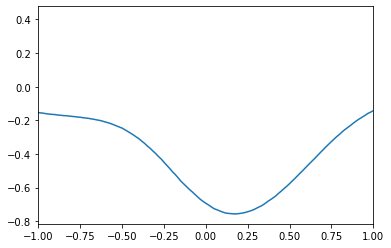

In [20]:
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')

plt.plot(T-T[int(len(T)/2)], nXcorr)
plt.xlim([-1, 1])

In [21]:
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, [-1,1])

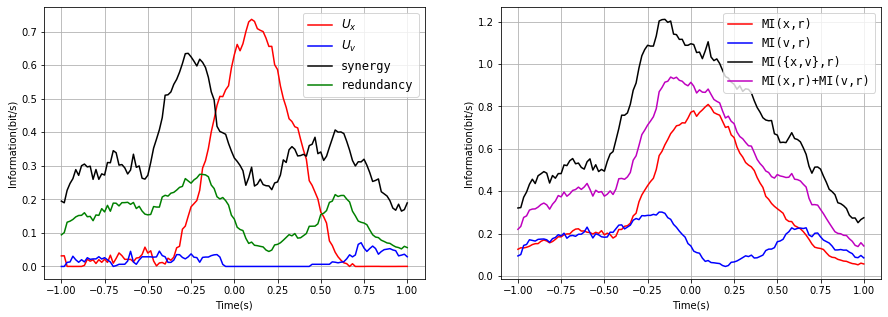

In [22]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')],'r-')
ax2.plot(timeshift,Information[('Beer','UIv')],'b-')
ax2.plot(timeshift,Information[('Beer','Syn')],'k-')
ax2.plot(timeshift,Information[('Beer','Red')],'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()
    
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+
                   Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)